# Imports and Materials

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import numpy as np
import pmag as pm
from jmaps.journey import *
import zaalm as zm
import tidy3d as td
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.constants import c, epsilon_0
from qutip import *
td.config.logging_level = "ERROR"
material_list = ['diamond', 'nitride', 'oxide']
if 'mats' in dir() and np.all([m in mats for m in material_list]):
    print("mats already defined")
else:
    mats = pm.materials.init_materials(material_list, plot=False)
mats['nitride'] = mats['air']
mats['oxide'] = mats['air']
materials_env = JEnv('materials', {
    'material_list' : JSet(material_list),
})


Initializing diamond material
Initializing nitride material
Initializing oxide material


# Journey

## Journey Init

In [53]:
idler_wavelength = 1.31

######################################################### Mixer parameters #########################################################
layer_mats = ['diamond']
n_idler = [mats[mat].nk_model(td.C_0/idler_wavelength)[0] for mat in layer_mats]
layer_heights = [idler_wavelength/n_idler[i]/len(layer_mats) for i in range(len(layer_mats))]

min_width = 0.25
max_width = 0.65
num_widths = 10
swept_layer_widths = [np.linspace(min_width, max_width, num_widths) for _ in range(len(layer_mats))]
wl_min = 0.6
wl_max = 2.4
f_min = td.C_0 / wl_max
f_max = td.C_0 / wl_min
num_freqs=26
freqs = np.linspace(f_min, f_max, num_freqs)
mixer_env = JEnv('mixer', {
    'layer_heights' :      JVar(np.array(layer_heights)),
    'swept_layer_widths' : JVar(np.array(swept_layer_widths)),
    'chosen_layer_i' :     JSet(0),
    'num_modes' :          JSet(5),
    'freqs' :              JSet(freqs),
    'plotted_modes' :      JOpt(2),
    'plot_fields' :        JOpt(False),
    'plot_freq' :          JOpt(freqs[-1]),
})

mode_env = JEnv('mode', {
    'layer_mats' :       JSet(layer_mats),
    'bend_radius' :      JSet(0),
    'box_mat' :          JSet('air'),
    'cladding' :         JSet('air'),
    'target_neff' :      JSet(None),
    'web_modes' :        JSet(False),
    'plot_geom' :        JOpt(False),
    'material_library' : JOpt(mats),
    'return_fields' :    JOpt(False),
})

######################################################### Nonlinear Bahar Parameters#########################################################
nonlinear_env = JEnv('nonlinear', {
    #### Order of the signals is (signal, idler, pump A, pump B)
    'mode_nums' :         JVar([0, 0, 0, 0]),
    'mode_factors' :      JVar([1,-1,-1, 1]),
    'unit_ks' :           JVar([1, 0, 1,-1]),
})

net_momentum_env = JEnv('net_momentum', {
    'fixed_freqs' :       JVar(td.C_0/np.array([0.619, 1.31])),
    'fit_tol' :           JSet(1e-3),
    'poly_order' :        JSet(10),
    'num_freqs' :         JSet(1000),
})

n_approx_env = JEnv('n_approx', {
    'n0' : JSet(2.4),
})

overlap_mode_env = JEnv('overlap_mode', {
    # 'pump_freq_nearby' : JVar(420e12)
    'zero_momentum_tolerance' : JSet(0.1),
    'power_in_length' :         JSet(1), # How much power of the total 3D mode exists in the length specified
})

######################################################### ZAALM Parameters #########################################################
zaalm_env = JEnv('zaalm', {
    'power_A' : JSet(1e3),
    'power_B' : JSet(1e3),
    'Q_sig' : JSet(1e5),
    'finesse_A' : JSet(400),
    'finesse_B' : JSet(400),
    'print_coeffs' : JOpt(False),
    'max_time' : JSet(1e-10),
    'time_res' : JSet(8001),
    'n_up' : JSet(1),
    'n_down' : JSet(1)
})

######################################################### WG FDTD Parameters #########################################################
wg_geom_env = JEnv('wg_geom', {
    'length' : JSet(10e-6),
})


##################################################### Component creation environments #####################################################
layer_kwargs = {
    "oxide_thickness": 5,
    "nitride_thickness": 5,
    "diamond_thickness": layer_heights[0]
}
pdk = pm.pdks.get_hybrid_cav_pdk()
pdk.activate()
layer_stack = pm.layers.get_hybrid_layer_stack(**layer_kwargs)

component_env = JEnv('component', {
    'material_mapping': JOpt(mats),
    'pad_xy_inner':     JSet(0),
    'pad_xy_outer':     JSet(1),
    'pad_z_inner':      JSet(0),
    'pad_z_outer':      JSet(0),
    'extend_ports':     JSet(0),
    'port_offset':      JSet(0),
    'layer_stack':      JOpt(layer_stack),
})
modeler_env = JEnv('modeler', {
    'center_z':       JSet("diamond"),
    'port_size_mult': JSet((6, 4)),
    'sim_size_z':     JSet(4),
    'crop_x':         JSet(-1),
    'crop_y':         JSet(-4),
    'bandwidth':      JSet(0),
    'num_freqs':      JSet(1),
    'symmetry':       JSet((0,0,0)),
    'mode_spec':      JOpt(td.ModeSpec(num_modes=5, filter_pol="te")),
    'boundary_spec':  JOpt(td.BoundarySpec(
                         x=td.Boundary(minus=td.PML(), plus=td.PML()),
                         y=td.Boundary(minus=td.PML(), plus=td.PML()),
                         z=td.Boundary(minus=td.PML(), plus=td.PML())))
})

##################################################### Custom FDTD environments #####################################################
wg_fdtd_env = JEnv('wg_fdtd', {
    'inputs':      JSet({'o1': {
                        'modes': [0],
                        'amps': [1],
                        'phases': [0],
                        }
                   }),
    'outputs':     JSet(['o1', 'o2']),
    'z_monitor':   JSet('diamond'),
    'z_freq':      JSet(None),
    'z_thickness': JSet(2),
    'interval_space': JSet((1,1,1))
})
wg_modeler_env = JEnv('wg_modeler', {
    'wavelength' : JSet(idler_wavelength),
})
wg_modeler_env['run_time'] = JSet((0.5*(wg_modeler_env['wavelength']-0.619) + 1.4)*1e-12)
wg_modeler_env['min_steps_per_wvl'] = JSet(int(50/3*(wg_modeler_env['wavelength']-0.619) + 10)) # Heuristic for min steps per wavelength


###################################################### Full Device #####################################################
separation_discretization = idler_wavelength
wg_separation = 15/2*separation_discretization  
# wg_length = wg_separation*0.8
resonator_env = JEnv('resonator', {
    'wg_separation'        : JSet(wg_separation),
    # 'wg_length'            : wg_length,
    # 'wg_width'             : 0.17,
    'final_euler_width'    : JSet(0.9),
    'straight_taper_length': JSet(0),
    'straight_taper_end_w' : JSet(.5),
    'support_width'        : JSet(0),
    'support_base'         : JSet(False),
    'use_bottom_taper'     : JSet(True),
    'ttype'                : JSet('sine'),
})

###################################################### Journey #####################################################
journey = Journey('nonlinear_dev', envs=[mixer_env, mode_env, materials_env, overlap_mode_env, net_momentum_env, nonlinear_env, zaalm_env, n_approx_env, 
                                        wg_fdtd_env, wg_modeler_env, wg_geom_env, component_env, modeler_env, resonator_env], 
                                        parent_cache_dir=Path('/home/floresh2/orcd/pool/jmaps/cache'))


In [34]:
print(layer_heights)

[np.float64(0.5485170442764464)]


## Path - Neff mixer

In [54]:
class NeffPath(JPath):
    @property
    def name(self) -> str:
        """Unique name of the path"""
        return "neff"
    @property
    def env_names(self) -> set[str]:
        """List of required environment names"""
        return set(['mixer', 'mode', 'materials'])
    def _run(self, envs, subpath_results, verbose: bool=False):
        # Temporarily set plotted_modes to 0
        result = {}
        result['plotted_modes'] = envs['mixer']['plotted_modes']
        envs['mixer']['plotted_modes'] = 0
        neff_mixer = pm.nonlinear.get_neff_mixer(**envs['mixer'], mode_args=envs['mode'])
        envs['mixer']['plotted_modes'] = result['plotted_modes']
        result['neff_mixer'] = neff_mixer
        return result
    def ponder(self, result, subpath_results):
        for mode_i in range(result['plotted_modes']):
            result['neff_mixer'].plot(mode_num=mode_i)
mixer_path = NeffPath()
journey.add_path(mixer_path)

Loaded previous result for neff from: /home/floresh2/orcd/pool/jmaps/cache/neff/ce202eafce4759d202fdcee4ace920be2a26f2ef8a3438021aaa73a2d4a71c47.dill


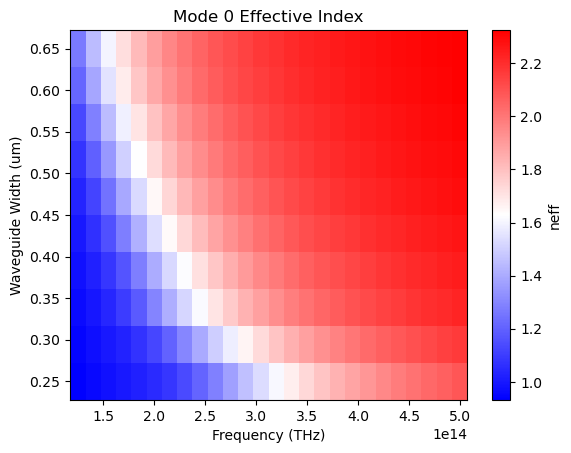

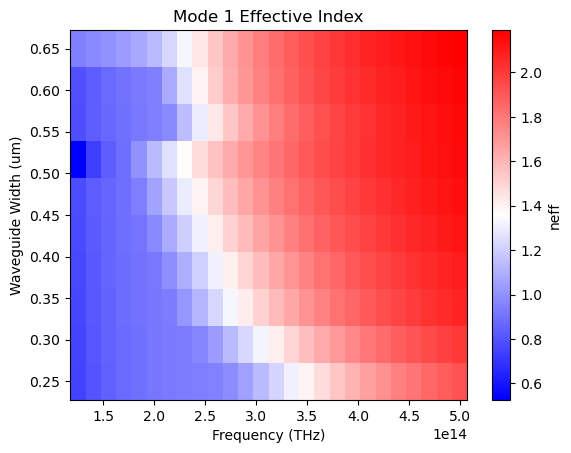

In [55]:
n_mixer, _,_ = journey.run_path('neff', verbose=True)

## Path - Bahar Coefficient from mode solver

In [56]:
class NonlinearCoeffPath(JPath):
    @property
    def name(self) -> str:
        """Unique name of the path"""
        return "nonlinear_coeff"
    @property
    def env_names(self) -> set[str]:
        """List of required environment names"""
        return set(['overlap_mode', 'net_momentum', 'nonlinear', 'mixer', 'mode', 'n_approx', 'materials', 'wg_geom'])

    @property
    def subpaths(self) -> set[str]:
        return set(['neff'])

    def _run(self, envs, subpath_results, verbose: bool=False):
        # Temporarily set plotted_modes to 0
        n_mixer = subpath_results['neff']['neff_mixer']
        f_A, f_B, net_momentum_matrix, min_n_matrix = n_mixer.net_momentum_matrix(**envs['nonlinear'], **envs['net_momentum'], plot=False)

        # For each width, find the frequency that minimizes the momentum mismatch
        zeroed_momentum_freqs = []
        min_momentums = []
        min_n_list = []
        for w_i, width in enumerate(n_mixer.layer_widths):
            min_momentum_i = np.argmin(np.abs(net_momentum_matrix[w_i, :]))
            if np.abs(net_momentum_matrix[w_i, min_momentum_i]) < envs['overlap_mode']['zero_momentum_tolerance']:
                min_n_list.append(min_n_matrix[w_i, min_momentum_i])
            else:
                min_n_list.append(0)
            min_momentums.append(net_momentum_matrix[w_i, min_momentum_i])
            zeroed_momentum_freqs.append(np.array([f_A[min_momentum_i], f_B[min_momentum_i]]))
        zeroed_momentum_freqs = np.array(zeroed_momentum_freqs)
        
        if 'pump_freq_nearby' in envs['overlap_mode']:
            # Find the width that minimizes the momentum mismatch with a pump frequency closest to the desired pump frequency
            closest_pump_freq_flati = np.argmin(np.abs(zeroed_momentum_freqs.flatten() - envs['overlap_mode']['pump_freq_nearby']))
            chosen_width_i = np.unravel_index(closest_pump_freq_flati, zeroed_momentum_freqs.shape)[0]
        else:
            # Find the width that maximizes the minimum effective index
            chosen_width_i = np.argmax(min_n_list)

        # Prepare arguments for mode solver
        pump_freqs = zeroed_momentum_freqs[chosen_width_i]
        overlap_freqs = np.concatenate((envs['net_momentum']['fixed_freqs'], pump_freqs))
        layer_widths = (envs['mixer']['swept_layer_widths'])[:, chosen_width_i]
        layer_heights = envs['mixer']['layer_heights']
        num_modes = envs['mixer']['num_modes']
        temp_field_setting = envs['mode']['return_fields']
        envs['mode']['return_fields'] = JOpt(True)

        # Run mode solver
        mode_data, mode_solver, n2 = pm.nonlinear.get_waveguide_modes(layer_widths, layer_heights, overlap_freqs, num_modes, **envs['mode'], return_n2=True)
        envs['mode']['return_fields'] = temp_field_setting
        
        n2_max = np.max(n2)
        chi3, _ = pm.nonlinear.get_nonlinear_coeffs(n2_max, envs['n_approx']['n0'])
        overlap_2D = pm.nonlinear.get_overlap_2D(mode_data, mode_freqs=overlap_freqs, **envs['nonlinear'], n2_mask=n2)
        
        L = envs['wg_geom']['length']
        delta_beta = min_momentums[chosen_width_i]
        overlap_3D = np.abs(overlap_2D*np.exp(1j*delta_beta*L/2)*np.sinc(delta_beta*L/2)/L*envs['overlap_mode']['power_in_length']**2)
        

        agrawal_gamma = overlap_3D* np.sum(layer_heights)*1e-6 * 2*np.pi*np.mean(overlap_freqs)/ c
        bahar_gamma = agrawal_gamma*2/(2*np.pi*np.mean(overlap_freqs)*epsilon_0*chi3)

        # Store results
        result = {}
        result['net_momentum_envs'] = {'nonlinear': envs['nonlinear'], 'net_momentum': envs['net_momentum']}
        if 'pump_freq_nearby' in envs['overlap_mode']:
            result['pump_freq_nearby'] = envs['overlap_mode']['pump_freq_nearby']
        result['overlap_freqs'] = overlap_freqs
        result['overlap_2D'] = overlap_2D
        result['overlap_3D'] = overlap_3D
        result['agrawal_gamma'] = agrawal_gamma
        result['bahar_gamma'] = bahar_gamma.values
        result['zeroed_momentum_freqs'] = zeroed_momentum_freqs
        result['min_n_list'] = min_n_list
        result['chosen_width'] = n_mixer.layer_widths[chosen_width_i]
        result['mode_data'] = mode_data
        result['n2'] = n2
        result['chi3'] = float(chi3)
        return result
        
    def ponder(self, result, subpath_results):
        n_mixer = subpath_results['neff']['neff_mixer']
        n_mixer.net_momentum_matrix(**result['net_momentum_envs']['nonlinear'], **result['net_momentum_envs']['net_momentum'], plot=True, center_colorbar=True)
        if 'pump_freq_nearby' in result:
            plt.figure()
            plt.plot(n_mixer.layer_widths, result['zeroed_momentum_freqs'][:,0]/1e12, label='Pump A')
            plt.plot(n_mixer.layer_widths, result['zeroed_momentum_freqs'][:,1]/1e12, label='Pump B')
            plt.axvline(result['chosen_width'], color='k', linestyle='--', label='Chosen Width')
            plt.axhline(result['pump_freq_nearby']/1e12, color='r', linestyle='--', label='Desired Pump Frequency')
            plt.xlabel('Layer Width (um)')
            plt.ylabel('Pump Frequency (THz)')
            plt.title('Zeroed Momentum Frequencies')
            plt.legend()
            plt.show()
        else:
            plt.figure()
            plt.plot(n_mixer.layer_widths, result['min_n_list'])
            plt.axvline(result['chosen_width'], color='k', linestyle='--', label='Chosen Width')
            plt.xlabel('Layer Width (um)')
            plt.ylabel('Effective Index')
            plt.title('Minimum Effective Index in Interaction')
    
    def evaluate(self, result: Any, subpath_results: dict[str, Any]) -> float:
        return result['bahar_gamma']
nonlinear_coeff_path = NonlinearCoeffPath()
journey.add_path(nonlinear_coeff_path)

Loaded previous result for neff from: /home/floresh2/orcd/pool/jmaps/cache/neff/ce202eafce4759d202fdcee4ace920be2a26f2ef8a3438021aaa73a2d4a71c47.dill
Packed for new nonlinear_coeff run to: /home/floresh2/orcd/pool/jmaps/cache/nonlinear_coeff/41cc991b974111373711d09621ff6201057f301890bfafc3ad2eef73dcdb501a.dill


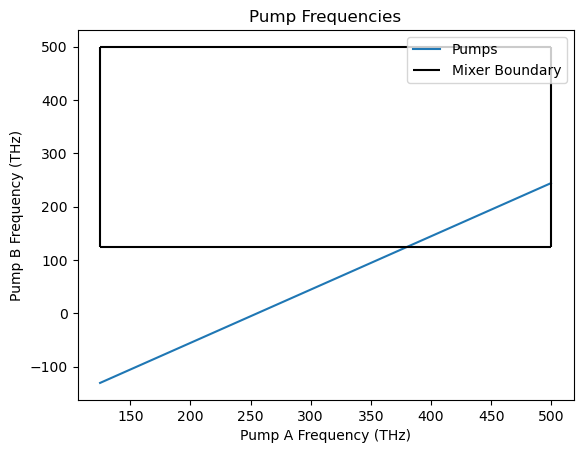

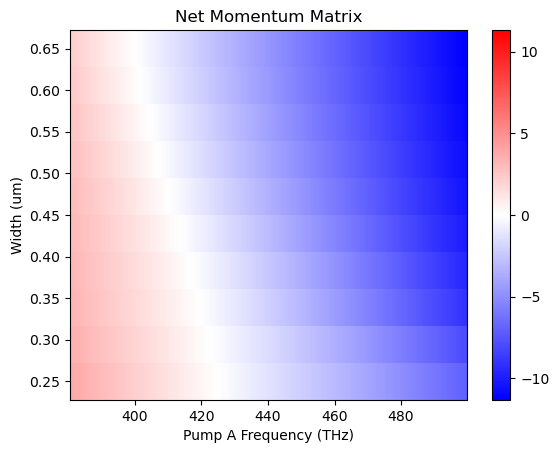

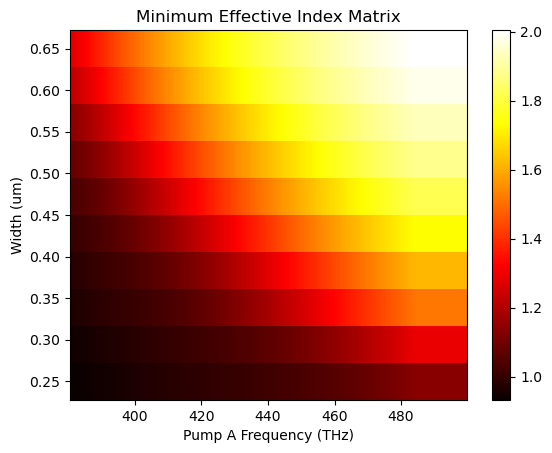

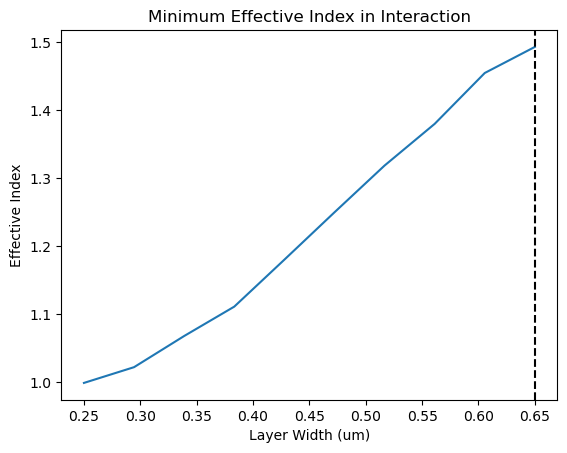

In [57]:
bahar_result, _,result_filepath = journey.run_path('nonlinear_coeff', verbose=True, force_run=True)

In [58]:
print(bahar_result['overlap_2D'])
print(bahar_result['overlap_3D'])
print(bahar_result['agrawal_gamma'])
print(bahar_result['bahar_gamma'])

2.9059027631749215e-07
0.02905902763174912
0.10501694902853007
7184346366688409.0


## Path - FDTD Verification of Bahar

In [9]:
import gdsfactory as gf
from jmaps.paths.tidy3d import GDS_Tidy3DPath
class WG_FDTDPath(GDS_Tidy3DPath):
    def __init__(self, delete_server_data: bool=False):
        super().__init__(custom_fdtd = 'wg_fdtd', custom_modeler = 'wg_modeler', delete_server_data=delete_server_data)

    @property
    def name(self) -> str:
        """Unique name of the path"""
        return 'wg_fdtd'

    @property
    def _env_names(self) -> list[str]:
        """List of required environment names"""
        return set(['wg_geom'])
    
    @property
    def subpaths(self) -> set[str]:
        return set(['nonlinear_coeff'])

    def get_component(self, envs: dict[str, JEnv], subpath_results: dict[str, Any], batch_i: int=0):
        x_section = pm.pdks.custom_x(width=subpath_results['nonlinear_coeff']['chosen_width'], layer='DIAMOND')
        return gf.components.straight(length=envs['wg_geom']['length']*1e6, cross_section=x_section)

class WG_BaharFDTDPath(JPath):
    @property
    def name(self) -> str:
        """Unique name of the path"""
        return 'wg_bahar_fdtd'

    @property
    def env_names(self) -> set[str]:
        """List of required environment names"""
        return set(['wg_geom'])
    
    @property
    def subpaths(self) -> set[str]:
        return set(['wg_fdtd', 'nonlinear_coeff'])

    def _run(self, envs: dict[str, JEnv], subpath_results: dict[str, Any], verbose: bool=False):
        '''This method must be overridden to provide functionality for the path. This might include simulations, computations, data collection, etc.
        If you wish there was another argument to the _run method, it probably should actually be an environment parameter.
        Args:
            envs (dict[str, JEnv]): The environments of parameters to run the path with.
            subpath_results (dict[str, Any]): The results of the subpaths.
            verbose (bool): Whether to print verbose output.
        '''
        min_x = 0
        max_x = envs['wg_geom']['length']*1e6
        res_x = len(subpath_results['wg_fdtd'][f'w0'][0]['field'].Ex.x.values)

        min_y = np.min(subpath_results['wg_fdtd'][f'w0'][0]['field'].Ex.y.values)
        max_y = np.max(subpath_results['wg_fdtd'][f'w0'][0]['field'].Ex.y.values)
        res_y = len(subpath_results['wg_fdtd'][f'w0'][0]['field'].Ex.y.values)
        min_z = np.min(subpath_results['wg_fdtd'][f'w0'][0]['field'].Ex.z.values)
        max_z = np.max(subpath_results['wg_fdtd'][f'w0'][0]['field'].Ex.z.values)
        res_z = len(subpath_results['wg_fdtd'][f'w0'][0]['field'].Ex.z.values)
        x_interp = np.linspace(min_x, max_x, res_x)
        y_interp = np.linspace(min_y, max_y, res_y)
        z_interp = np.linspace(min_z, max_z, res_z)
        efields = []
        method= 'linear'
        for i in range(len(subpath_results['wg_fdtd'])):
            original_field = subpath_results['wg_fdtd'][f'w{i}'][0]['field']
            # coords = original_field.Ex.coords
            coords={
                    "x": x_interp,
                    "y": y_interp,
                    "z": z_interp,
                    "f": original_field.Ex.f.values,
                }
            dataset_E = td.FieldDataset(
                Ex=td.ScalarFieldDataArray(
                    original_field.Ex.interp(x=x_interp, y=y_interp, z=z_interp, method=method, assume_sorted=True).values,
                    coords=coords),
                Ey=td.ScalarFieldDataArray(
                    original_field.Ey.interp(x=x_interp, y=y_interp, z=z_interp, method=method, assume_sorted=True).values,
                    coords=coords),
                Ez=td.ScalarFieldDataArray(
                    original_field.Ez.interp(x=x_interp, y=y_interp, z=z_interp, method=method, assume_sorted=True).values,
                    coords=coords))
            efields.append(dataset_E)
        coords = td.Coords(x=x_interp, y=y_interp, z=z_interp)
        n2 = pm.nonlinear.n2_on_coords(sim=subpath_results['wg_fdtd']['w0'][0].simulation, coords=coords)
        result = {}
        result['efields'] = efields
        result['n2'] = n2
        return result

    def subpath_batches(self, envs: dict[str, JEnv], subpath_results_singles: dict[str, Any]) -> dict[str, JBatch]:
        wg_batch = JBatch()
        for freq_i, freq in enumerate(subpath_results_singles['nonlinear_coeff']['overlap_freqs']):
            wg_modeler = JEnv('wg_modeler', {
                'wavelength' : JSet(td.C_0/freq),
            })
            wg_modeler['run_time'] = JSet((0.5*(wg_modeler['wavelength']-0.619) + 1.4)*1e-12)
            wg_modeler['min_steps_per_wvl'] = JSet(int(50/3*(wg_modeler['wavelength']-0.619) + 15)) # Heuristic for min steps per wavelength

            wg_batch.add_run(batch_id=f'w{freq_i}', envs=[wg_modeler])
        return {'wg_fdtd' : wg_batch}
    
    @property   
    def subpath_batch_envs(self) -> dict[str, set[str]]:
        return {'wg_fdtd' : set(['wg_modeler'])}

Loaded previous result for nonlinear_coeff from: /home/floresh2/orcd/pool/jmaps/cache/nonlinear_coeff/41cc991b974111373711d09621ff6201057f301890bfafc3ad2eef73dcdb501a.dill
Packed for new wg_fdtd run to: /home/floresh2/orcd/pool/jmaps/cache/wg_fdtd/68f098b7d0c9f418fca1f821e0fef16a40097830ef8c21b320d46491c488c070.dill


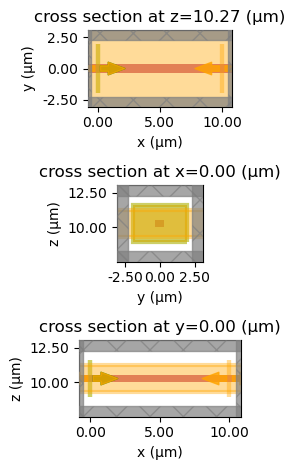

Grid size (5597760) and total time steps (35143) are within daily allowance.


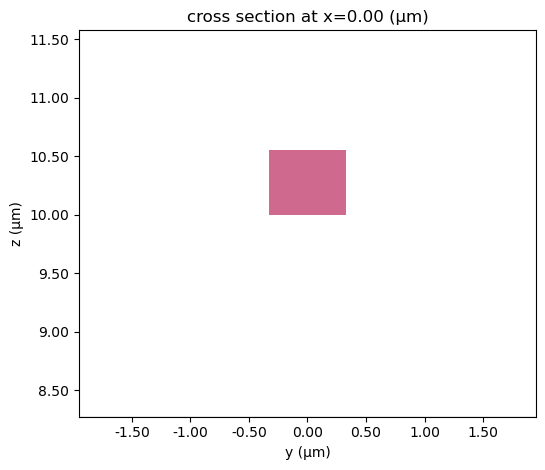

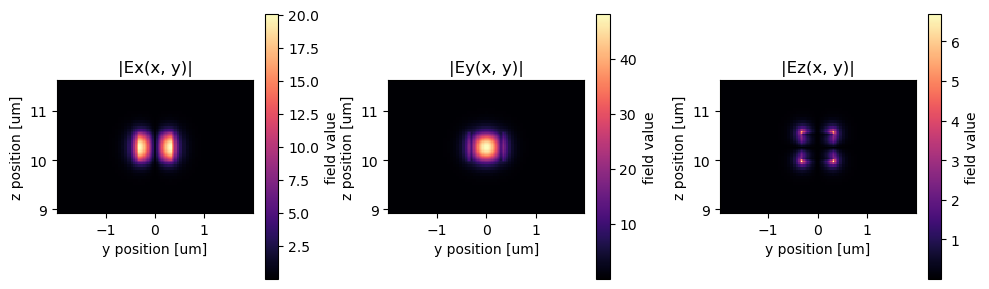

In [10]:
wg_fdtd_path = WG_FDTDPath(delete_server_data=False)
journey.add_path(wg_fdtd_path)
backpack = journey.pack_for_path(wg_fdtd_path.name, force_run=True)
wg_fdtd_path.plot_geom(backpack['safe_envs_stripped'], backpack['subpath_results'], layer_name='diamond')
wg_fdtd_path.plot_mode(backpack['safe_envs_stripped'], backpack['subpath_results'], mode_index=0, port_index=0, batch_i=0)

In [11]:
wg_bahar_fdtd_path = WG_BaharFDTDPath()
journey.add_path(wg_bahar_fdtd_path)

In [12]:
batch_results, _, result_filepath = journey.run_path(wg_bahar_fdtd_path.name, verbose=True, force_run=False)

Loaded previous result for nonlinear_coeff from: /home/floresh2/orcd/pool/jmaps/cache/nonlinear_coeff/41cc991b974111373711d09621ff6201057f301890bfafc3ad2eef73dcdb501a.dill
Loaded previous result for nonlinear_coeff from: /home/floresh2/orcd/pool/jmaps/cache/nonlinear_coeff/41cc991b974111373711d09621ff6201057f301890bfafc3ad2eef73dcdb501a.dill
Packed for new wg_fdtd run to: /home/floresh2/orcd/pool/jmaps/cache/wg_fdtd/5d88342d6763e6b0cdf3c02495f13ba2223aafd66ff79cafa991d2668ffbed12.dill


Output()

15:00:26 EDT Started working on Batch containing 1 tasks.

15:00:27 EDT Maximum FlexCredit cost: 0.269 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

15:00:28 EDT Batch complete.

Output()

Output()

Loaded previous result for nonlinear_coeff from: /home/floresh2/orcd/pool/jmaps/cache/nonlinear_coeff/41cc991b974111373711d09621ff6201057f301890bfafc3ad2eef73dcdb501a.dill
Packed for new wg_fdtd run to: /home/floresh2/orcd/pool/jmaps/cache/wg_fdtd/56918b2f6c399c16dd279224a3d35fc5e863dc332593e50f71e5c64501860d0a.dill


15:00:35 EDT Started working on Batch containing 1 tasks.

15:00:36 EDT Maximum FlexCredit cost: 0.159 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

15:00:37 EDT Batch complete.

Output()

Output()

Loaded previous result for nonlinear_coeff from: /home/floresh2/orcd/pool/jmaps/cache/nonlinear_coeff/41cc991b974111373711d09621ff6201057f301890bfafc3ad2eef73dcdb501a.dill
Packed for new wg_fdtd run to: /home/floresh2/orcd/pool/jmaps/cache/wg_fdtd/f07845fd864e8eefb9ab191456515836b8894c50fc36e4c35f70c049854a9f34.dill


15:00:42 EDT Started working on Batch containing 1 tasks.

15:00:43 EDT Maximum FlexCredit cost: 0.219 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

             Batch complete.

Output()

Output()

Loaded previous result for nonlinear_coeff from: /home/floresh2/orcd/pool/jmaps/cache/nonlinear_coeff/41cc991b974111373711d09621ff6201057f301890bfafc3ad2eef73dcdb501a.dill
Packed for new wg_fdtd run to: /home/floresh2/orcd/pool/jmaps/cache/wg_fdtd/3a0469490649f751e02e5851c8d0aa0cd4d60188e03301e875babb70671b41b8.dill


15:00:49 EDT Started working on Batch containing 1 tasks.

15:00:50 EDT Maximum FlexCredit cost: 0.161 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

             Batch complete.

Output()

Packed for new wg_bahar_fdtd run to: /home/floresh2/orcd/pool/jmaps/cache/wg_bahar_fdtd/09fd0aa4872ef19d6cdffcef23d6c1a9b84865ad7b9ceb01e1876782fe359402.dill


overlap_3D*power_in_length**2: 0.029054531873186545
Error: 0.02%


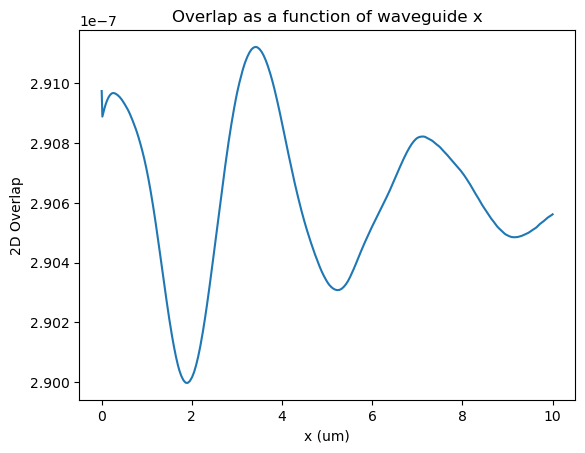

In [13]:
import xarray as xr

combined_Ex = xr.concat([batch_results['efields'][i].Ex for i in range(len(batch_results['efields']))], dim='f')
combined_Ey = xr.concat([batch_results['efields'][i].Ey for i in range(len(batch_results['efields']))], dim='f')
combined_Ez = xr.concat([batch_results['efields'][i].Ez for i in range(len(batch_results['efields']))], dim='f')
combined_E = td.FieldDataset(Ex=combined_Ex, Ey=combined_Ey, Ez=combined_Ez)
z_i = np.argmin(np.abs(combined_E.Ex.z.values-np.mean(combined_E.Ex.z.values)))
# combined_E.Ey.real.isel(f=0, z=z_i).plot(x='x', y='y')
overlap_3D, overlap_2D = pm.nonlinear.get_overlap_3D(combined_E, mode_freqs=combined_Ex.f.values, **journey.envs['nonlinear'].get_values(), n2_mask=batch_results['n2'])
overlap_power = overlap_3D*journey.envs['overlap_mode']['power_in_length']**2
print(f'overlap_3D*power_in_length**2: {overlap_power}')
error = (bahar_result['overlap_3D']-overlap_power)/overlap_power*100
print(f'Error: {error:0.2f}%')
plt.plot(combined_Ex.x.values, overlap_2D)
plt.xlabel('x (um)')
plt.ylabel('2D Overlap')
plt.title('Overlap as a function of waveguide x')
plt.show()

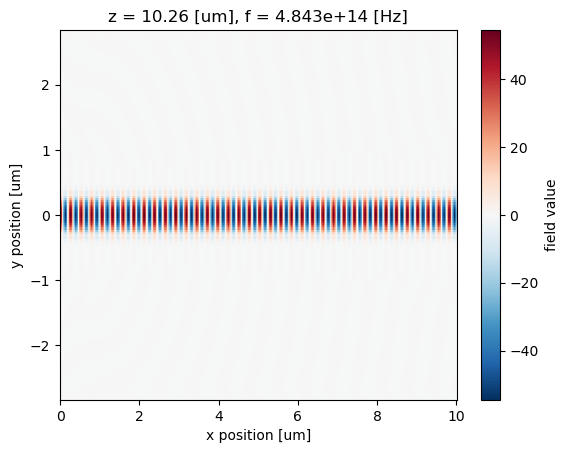

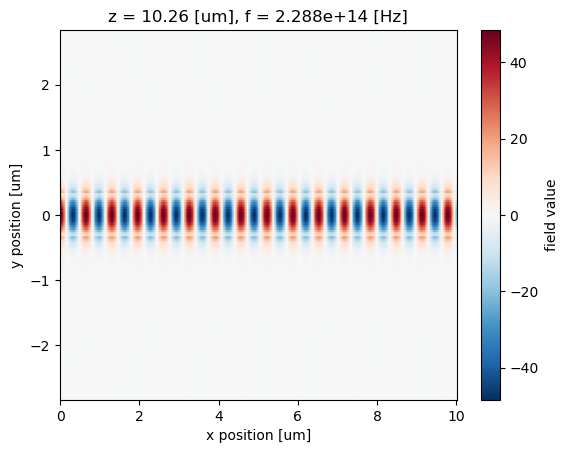

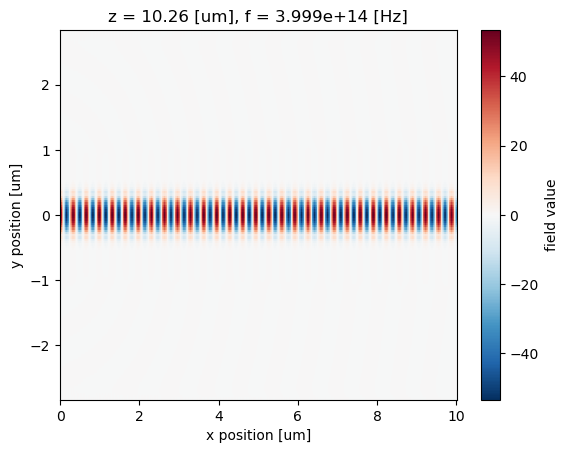

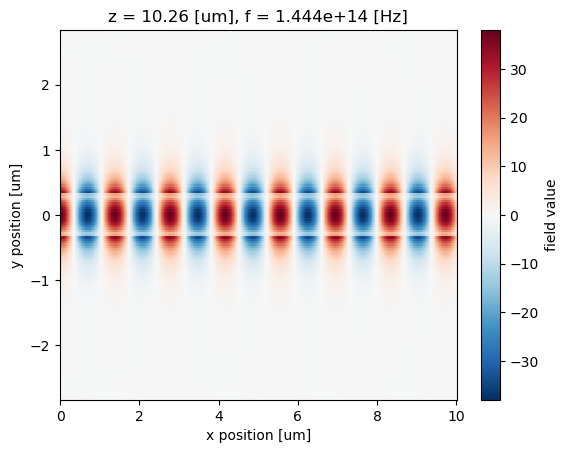

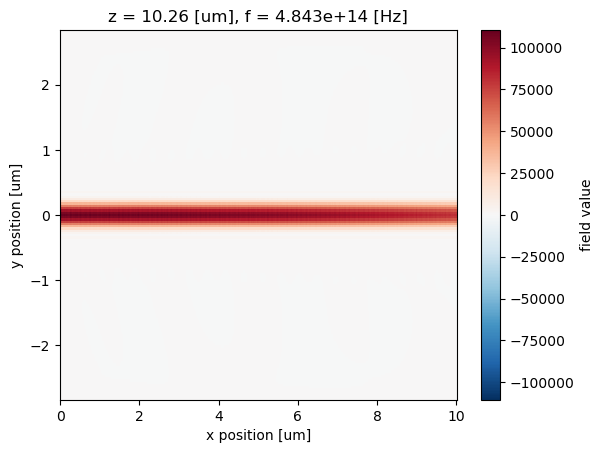

In [14]:
polarization = None
dxx = batch_results['efields'][0].Ex.x.values[1]-batch_results['efields'][0].Ex.x.values[0]
dyy = batch_results['efields'][0].Ex.y.values[1]-batch_results['efields'][0].Ex.y.values[0]
dzz = batch_results['efields'][0].Ex.z.values[1]-batch_results['efields'][0].Ex.z.values[0]
for i,efield in enumerate(batch_results['efields']):
    z_i = np.argmin(np.abs(efield.Ex.z.values-np.mean(efield.Ex.z.values)))
    efield.Ey.real.isel(z=z_i).plot(x='x', y='y')
    plt.show()
    conjugate = journey.envs['nonlinear']['unit_ks'][i]*journey.envs['nonlinear']['mode_factors'][i]
    if polarization is None:
        polarization = efield.Ey.isel(f=0).copy() if conjugate == 1 else np.conj(efield.Ey.isel(f=0)).copy() if conjugate == -1 else 1
    else:
        polarization *= efield.Ey.isel(f=0) if conjugate == 1 else np.conj(efield.Ey.isel(f=0)) if conjugate == -1 else 1



# z_i = np.argmin(np.abs(batch_results['n2'].z_range-batch_results['n2'].center[2]))
# print(polarization)
polarization.real.isel(z=z_i).plot(x='x', y='y')
plt.show()
# batch_results['n2'].plot(part='real', z_i=z_i)

## Path - ZAALM Conversion Efficiency from Bahar Coefficient

In [59]:
class SpectralZAALMPath(JPath):
    @property
    def name(self) -> str:
        """Unique name of the path"""
        return "spectra_zaalm"
    @property
    def env_names(self) -> set[str]:
        """List of required environment names"""
        return set(['zaalm', 'n_approx', 'mixer'])
    @property
    def subpaths(self) -> set[str]:
        return set(['nonlinear_coeff'])
    def _run(self, envs, subpath_results, verbose: bool=False):
        y_sig = c/subpath_results['nonlinear_coeff']['overlap_freqs'][0]
        y_idl = c/subpath_results['nonlinear_coeff']['overlap_freqs'][1]
        y_A = c/subpath_results['nonlinear_coeff']['overlap_freqs'][2]
        y_B = c/subpath_results['nonlinear_coeff']['overlap_freqs'][3]
        delta_k_space_up = 2*np.pi/y_idl*envs['n_approx']['n0']
        delta_k_space_down = -2*np.pi/y_idl*envs['n_approx']['n0']
        thickness = np.sum(envs['mixer']['layer_heights'])*1e-6
        
        """Calculate the Zaalm coupling efficiency."""
        # Convert wavelengths to frequencies
        f_sig = c/y_sig
        f_idl = c/y_idl
        f_A = c/y_A
        f_B = c/y_B

        w_sig = 2*np.pi*f_sig
        w_idl = 2*np.pi*f_idl
        w_A =  2*np.pi*f_A
        w_B = 2*np.pi*f_B

        nonlinear = subpath_results['nonlinear_coeff']
        eff_power_A = envs['zaalm']['power_A']*envs['zaalm']['finesse_A']/np.pi
        eff_power_B = envs['zaalm']['power_B']*envs['zaalm']['finesse_B']/np.pi

        # Decay and coupling constants
        kappa_idl_space=2*epsilon_0*float(nonlinear['chi3'])*np.sqrt(w_sig*w_idl*nonlinear['bahar_gamma']**2 * eff_power_A*eff_power_B)
        kappa_idl_time = kappa_idl_space*c/envs['n_approx']['n0']

        delta_k_eff_up = delta_k_space_up + epsilon_0*nonlinear['chi3']*nonlinear['bahar_gamma']/2*(w_B*eff_power_B - w_A*eff_power_A)
        delta_k_time_up = delta_k_eff_up*c/envs['n_approx']['n0']

        delta_k_eff_down = delta_k_space_down + epsilon_0*nonlinear['chi3']*nonlinear['bahar_gamma']/2*(w_B*eff_power_B - w_A*eff_power_A)
        delta_k_time_down = delta_k_eff_down*c/envs['n_approx']['n0']

        decay_sig = 2*np.pi*f_sig/envs['zaalm']['Q_sig']


        rt_tau_idl = thickness/c*envs['n_approx']['n0']*2
        R_idl_up = ((envs['n_approx']['n0']-envs['zaalm']['n_up'])/(envs['n_approx']['n0']+envs['zaalm']['n_up']))**2
        R_idl_down = ((envs['n_approx']['n0']-envs['zaalm']['n_down'])/(envs['n_approx']['n0']+envs['zaalm']['n_down']))**2

        lifetime_idl_up = -rt_tau_idl/np.log(R_idl_up)
        lifetime_idl_down = -rt_tau_idl/np.log(R_idl_down)

        r_idl_down = -np.log(1-R_idl_down)/rt_tau_idl
        r_idl_up = -np.log(1-R_idl_up)/rt_tau_idl

        decay_idl_up = 1/lifetime_idl_up
        decay_idl_down = 1/lifetime_idl_down

        N_sig = 2                             # number of cavity fock states
        N_idler = 2                           # number of cavity fock states
        a_sig  = tensor(destroy(N_sig), qeye(N_idler), qeye(N_idler))
        a_idler_up  = tensor(qeye(N_sig), destroy(N_idler), qeye(N_idler))
        a_idler_down  = tensor(qeye(N_sig), qeye(N_idler), destroy(N_idler))
        number_sig = a_sig.dag() * a_sig
        number_idl_up = a_idler_up.dag() * a_idler_up
        number_idl_down = a_idler_down.dag() * a_idler_down

        H = kappa_idl_time/2*(a_sig.dag()*a_idler_up + a_sig * a_idler_up.dag())       # Coupling to up idler modes
        H += kappa_idl_time/2*(a_sig.dag()*a_idler_down + a_sig * a_idler_down.dag())  # Coupling to down idler modes
        H += r_idl_down*(a_idler_down.dag()*a_idler_up) + r_idl_up*(a_idler_up.dag()*a_idler_down) # Reflection coupling between idler modes
        H += delta_k_time_up/2 * (number_sig - number_idl_up)          # Dephasing
        H += delta_k_time_down/2 * (number_sig - number_idl_down)

        # collapse operator for the signal in the cavity mode
        c_ops=[]
        c_ops = [np.sqrt(decay_sig) * a_sig]
        # Include collapse operator for the idler 1550 nm escaping
        c_ops += [np.sqrt(decay_idl_up) * a_idler_up]
        c_ops += [np.sqrt(decay_idl_down) * a_idler_down]

        psi0 = tensor(basis(N_sig, 1), basis(N_idler, 0), basis(N_idler, 0))
        tlist = np.linspace(0, envs['zaalm']['max_time'], envs['zaalm']['time_res'])  # 0 to 100 ns, for example

        e_ops = [number_sig, number_idl_up, number_idl_down]  # we want to record <n_sig> and <n_idl> vs. time
        result = mesolve(H, psi0, tlist, c_ops, e_ops, options={"nsteps":1e7})
        n_sig_t = result.expect[0]  # <n_sig>(t)
        n_idl_t_up = result.expect[1]  # <n_idl>(t)
        n_idl_t_down = result.expect[2]  # <n_idl>(t)

        if envs['zaalm']['print_coeffs']:
            print(f"y_sig: {y_sig}, y_idl: {y_idl}, y_A: {y_A}, y_B: {y_B}")
            print(f"Idler Coupling in Time: {kappa_idl_time:0.2f} s^-1")
            print(f"Signal Decay Constant: {decay_sig:.2f} s^-1")
            # print(f"Idler Fabry Perot Q: {fabry_perot_Q:.2f}")
            print(f"Idler Decay Constant Up: {decay_idl_up:.2f} s^-1")
            print(f"Idler Decay Constant Down: {decay_idl_down:.2f} s^-1")
            print(f"Delta k up in Time: {delta_k_time_up:.2f} s^-1")
            print(f"Delta k down in Time: {delta_k_time_down:.2f} s^-1")
            print(f"Coupling to signal decay ratio: {kappa_idl_time/decay_sig:.2f}")
            print(f"Coupling to idler decay ratio: {kappa_idl_time/decay_idl_up:.2f}")
            print(f"Idler up dephasing/decay ratio: {delta_k_time_up/decay_idl_up:.2f}")
            print(f"Idler down dephasing/decay ratio: {delta_k_time_down/decay_idl_up:.2f}")

        dissipation_rate_sig   = decay_sig   * n_sig_t
        coupling_rate_sig   = kappa_idl_time * n_sig_t
        dissipation_rate_idler_up = decay_idl_up * n_idl_t_up
        dissipation_rate_idler_down = decay_idl_down * n_idl_t_down

        # integrate using the trapezoid rule
        sig_loss_total   = np.trapezoid(dissipation_rate_sig, x=tlist)
        idler_loss_total_up = np.trapezoid(dissipation_rate_idler_up, x=tlist)
        idler_loss_total_down = np.trapezoid(dissipation_rate_idler_down, x=tlist)
        idler_loss_total = idler_loss_total_up + idler_loss_total_down
        idler_up_down_ratio = idler_loss_total_up / idler_loss_total_down
        norm_idler = idler_loss_total/(sig_loss_total+ idler_loss_total)
        result = {}
        # Save plotting information
        result['tlist'] = tlist
        result['n_sig_t'] = n_sig_t
        result['n_idl_t_up'] = n_idl_t_up
        result['n_idl_t_down'] = n_idl_t_down
        result['dissipation_rate_sig'] = dissipation_rate_sig
        result['dissipation_rate_idler_up'] = dissipation_rate_idler_up
        result['dissipation_rate_idler_down'] = dissipation_rate_idler_down
        result['coupling_rate_sig'] = coupling_rate_sig

        # Save figures of merit
        result['sig_loss_total'] = sig_loss_total
        result['idler_loss_total_up'] = idler_loss_total_up
        result['idler_loss_total_down'] = idler_loss_total_down
        result['idler_loss_total'] = idler_loss_total
        result['idler_up_down_ratio'] = idler_up_down_ratio
        result['norm_idler'] = norm_idler
        return result
    def ponder(self, result, subpath_results):
        plt.figure()
        plt.plot(result['tlist']*1e12, result['n_sig_t'], label='⟨n_sig⟩')
        plt.plot(result['tlist']*1e12, result['n_idl_t_up'], label='⟨n_idl_up⟩')
        plt.plot(result['tlist']*1e12, result['n_idl_t_down'], label='⟨n_idl_down⟩')
        plt.xlabel("time (ps)")
        plt.ylabel("photon number")
        plt.legend()
        plt.title("Mode populations vs time")
        # plt.xlim(0,100)
        plt.show()

        plt.figure()
        plt.plot(result['tlist']*1e12, result['dissipation_rate_sig'], label='signal dissipation rate')
        # plt.plot(tlist/v_idler*1e12, coupling_rate_sig, label='signal coupling rate')
        plt.plot(result['tlist']*1e12, result['dissipation_rate_idler_up'], label='idler up dissipation rate')
        plt.plot(result['tlist']*1e12, result['dissipation_rate_idler_down'], label='idler down dissipation rate')
        plt.xlabel("time (ps)")
        plt.ylabel("photon-loss rate")
        plt.legend()
        plt.title("Dissipation rates vs time")
        plt.show()
    def evaluate(self, result: Any, subpath_results: dict[str, Any]) -> float:
        return result['norm_idler']

    
spectral_zaalm_path = SpectralZAALMPath()
journey.add_path(spectral_zaalm_path)

Loaded previous result for nonlinear_coeff from: /home/floresh2/orcd/pool/jmaps/cache/nonlinear_coeff/41cc991b974111373711d09621ff6201057f301890bfafc3ad2eef73dcdb501a.dill
Packed for new spectra_zaalm run to: /home/floresh2/orcd/pool/jmaps/cache/spectra_zaalm/af11c71a6203b828ce71c497d444dd9a9df77f4d7499423a07f5251d3d830b42.dill


/home/floresh2/.conda/envs/zm/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


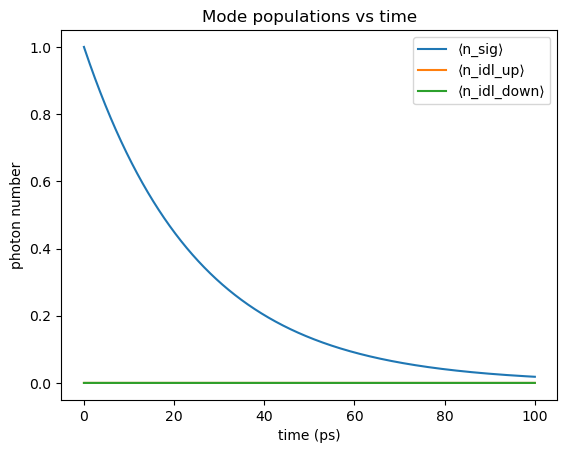

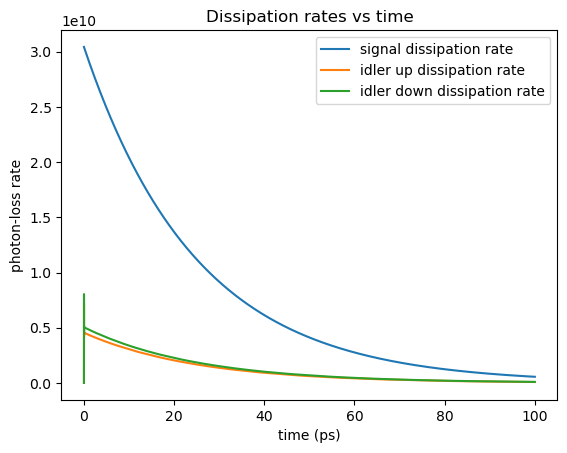

Spectral ZAALM Conversion Efficiency: 0.2395540736490727


In [60]:
result, _, filepath = journey.run_path('spectra_zaalm', verbose=True, force_run=False)
print(f'Spectral ZAALM Conversion Efficiency: {result["norm_idler"]}')

## Path - Half Device FDTD

In [41]:
import gdsfactory as gf
from jmaps.paths.tidy3d import GDS_Tidy3DPath
class Racetrack_FDTDPath(GDS_Tidy3DPath):
    def __init__(self, delete_server_data: bool=True):
        super().__init__(custom_fdtd='wg_fdtd', custom_modeler='wg_modeler',delete_server_data=delete_server_data)

    @property
    def name(self) -> str:
        """Unique name of the path"""
        return 'racetrack_fdtd'

    @property
    def _env_names(self) -> list[str]:
        """List of required environment names"""
        return set(['wg_geom', 'resonator'])
    
    @property
    def subpaths(self) -> set[str]:
        return set(['nonlinear_coeff'])

    def get_component(self, envs: dict[str, JEnv], subpath_results: dict[str, Any], batch_i: int=0):
        return pm.devices.tapered_racetrack.tapered_euler_resonator(wg_length=envs['wg_geom']['length']*1e6, wg_width=subpath_results['nonlinear_coeff']['chosen_width'], **envs['resonator'])

class HalfRace_BaharPath(JPath):
    def __init__(self):
        super().__init__()

    @property
    def name(self) -> str:
        """Unique name of the path"""
        return 'halfrace_bahar'

    @property
    def env_names(self) -> set[str]:
        return set(['wg_geom', 'resonator'])

    @property
    def subpaths(self) -> set[str]:
        return set(['nonlinear_coeff', 'racetrack_fdtd'])

    def _run(self, envs, subpath_results, verbose: bool=False):
        min_x = 0
        max_x = np.max(subpath_results['racetrack_fdtd'][f'w0'][0]['field'].Ex.x.values)
        res_x = len(subpath_results['racetrack_fdtd'][f'w0'][0]['field'].Ex.x.values)

        min_y = np.min(subpath_results['racetrack_fdtd'][f'w0'][0]['field'].Ex.y.values)
        max_y = np.max(subpath_results['racetrack_fdtd'][f'w0'][0]['field'].Ex.y.values)
        res_y = len(subpath_results['racetrack_fdtd'][f'w0'][0]['field'].Ex.y.values)
        min_z = np.min(subpath_results['racetrack_fdtd'][f'w0'][0]['field'].Ex.z.values)
        max_z = np.max(subpath_results['racetrack_fdtd'][f'w0'][0]['field'].Ex.z.values)
        res_z = len(subpath_results['racetrack_fdtd'][f'w0'][0]['field'].Ex.z.values)
        x_interp = np.linspace(min_x, max_x, res_x)
        y_interp = np.linspace(min_y, max_y, res_y)
        z_interp = np.linspace(min_z, max_z, res_z)
        efields = []
        transmissions = []
        method= 'linear'
        for i in range(len(subpath_results['racetrack_fdtd'])):
            transmission = subpath_results['racetrack_fdtd'][f'w{i}'][0]['o2'].amps.sel(direction="-")[0, 0].values
            transmissions.append(transmission)
            original_field = subpath_results['racetrack_fdtd'][f'w{i}'][0]['field']
            # coords = original_field.Ex.coords
            coords={
                    "x": x_interp,
                    "y": y_interp,
                    "z": z_interp,
                    "f": original_field.Ex.f.values,
                }
            dataset_E = td.FieldDataset(
                Ex=td.ScalarFieldDataArray(
                    original_field.Ex.interp(x=x_interp, y=y_interp, z=z_interp, method=method, assume_sorted=True).values,
                    coords=coords),
                Ey=td.ScalarFieldDataArray(
                    original_field.Ey.interp(x=x_interp, y=y_interp, z=z_interp, method=method, assume_sorted=True).values,
                    coords=coords),
                Ez=td.ScalarFieldDataArray(
                    original_field.Ez.interp(x=x_interp, y=y_interp, z=z_interp, method=method, assume_sorted=True).values,
                    coords=coords))
            efields.append(dataset_E)
        coords = td.Coords(x=x_interp, y=y_interp, z=z_interp)
        n2 = pm.nonlinear.n2_on_coords(sim=subpath_results['racetrack_fdtd']['w0'][0].simulation, coords=coords)
        result = {}
        result['efields'] = efields
        result['n2'] = n2
        result['transmissions'] = transmissions
        result['freqs'] = subpath_results['nonlinear_coeff']['overlap_freqs']
        return result

    @property
    def subpath_batch_envs(self) -> dict[str, set[str]] | None:
        return {'racetrack_fdtd' : set(['wg_modeler', 'component', 'modeler'])}
    def subpath_batches(self, envs, subpath_results_singles: dict[str, Any]) -> dict[str, JBatch]:
        approximate_dev_width = 2*1.5*envs['resonator']['wg_separation'] + 2*envs['wg_geom']['length']
        component_env = JEnv('component', {
            'material_mapping': JOpt(mats),
            'pad_xy_inner':     JSet(0),
            'pad_xy_outer':     JSet(0),
            'pad_z_inner':      JSet(0),
            'pad_z_outer':      JSet(0),
            'extend_ports':     JSet(0),
            'port_offset':      JSet(0),
            'layer_stack':      JOpt(layer_stack),
        })
        modeler_env = JEnv('modeler', {
            'center_z':       JSet("diamond"),
            'port_size_mult': JSet((6, 4)),
            'sim_size_z':     JSet(4),
            'crop_x':         JSet(approximate_dev_width/2-4),
            'shift_x':        JSet(approximate_dev_width/4),
            'crop_y':         JSet(-4),
            'bandwidth':      JSet(0),
            'num_freqs':      JSet(1),
            'symmetry':       JSet((0,0,0)),
            'mode_spec':      JOpt(td.ModeSpec(num_modes=5, filter_pol="te")),
            'boundary_spec':  JOpt(td.BoundarySpec(
                                x=td.Boundary(minus=td.PML(), plus=td.PML()),
                                y=td.Boundary(minus=td.PML(), plus=td.PML()),
                                z=td.Boundary(minus=td.PML(), plus=td.PML()))),
            'run_only':          JSet([('o1', 0)]),
        })
        
        halfrace_batch = JBatch()
        for freq_i, freq in enumerate(subpath_results_singles['nonlinear_coeff']['overlap_freqs']):
            wg_modeler = JEnv('wg_modeler', {
                'wavelength' : JSet(td.C_0/freq),
            })
            wg_modeler['run_time'] = JSet((0.5*(wg_modeler['wavelength']-0.619) + 1.4)*1e-12)
            wg_modeler['min_steps_per_wvl'] = JSet(int(50/3*(wg_modeler['wavelength']-0.619) + 15)) # Heuristic for min steps per wavelength

            halfrace_batch.add_run(batch_id=f'w{freq_i}', envs=[wg_modeler, component_env, modeler_env])
        return {'racetrack_fdtd' : halfrace_batch}

Loaded previous result for nonlinear_coeff from: /home/floresh2/orcd/pool/jmaps/cache/nonlinear_coeff/53476da4cb5ca90804da982bd3b6233f5ca139728c38a52a8af7bb361e40e6f7.dill
Packed for new racetrack_fdtd run to: /home/floresh2/orcd/pool/jmaps/cache/racetrack_fdtd/cf3ab2d7036e64c1c745fc5218d8a485bfc03f420a254fe587e97f4d2b88a088.dill


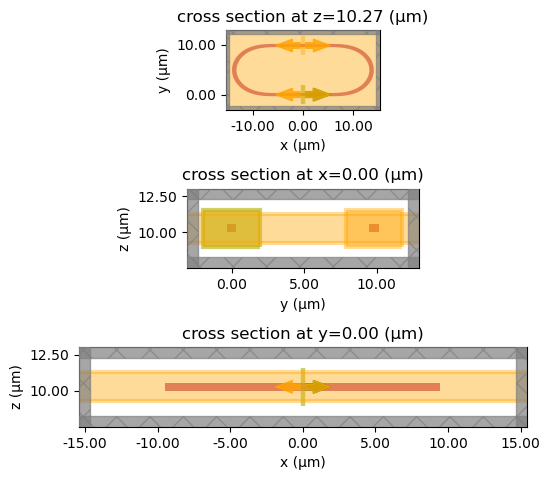

Grid size (59006640) and total time steps (35455) are within daily allowance.


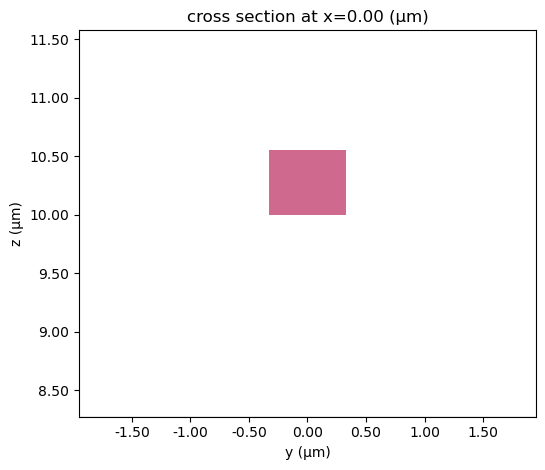

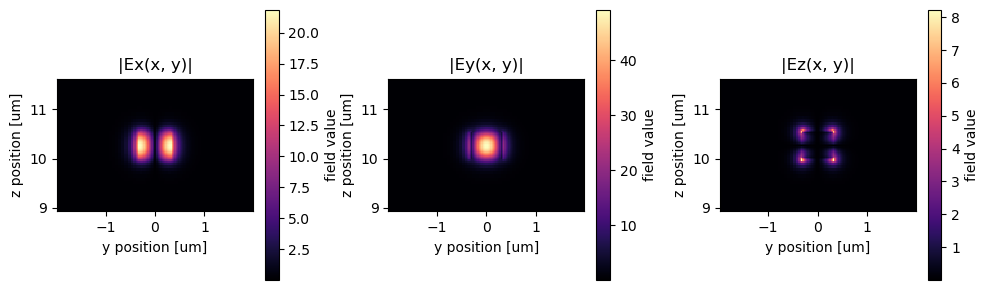

In [42]:
halfrace_fdtd_path = Racetrack_FDTDPath(delete_server_data=False)
journey.add_path(halfrace_fdtd_path)
backpack = journey.pack_for_path(halfrace_fdtd_path.name, force_run=True)
halfrace_fdtd_path.plot_geom(backpack['safe_envs_stripped'], backpack['subpath_results'], layer_name='diamond')
halfrace_fdtd_path.plot_mode(backpack['safe_envs_stripped'], backpack['subpath_results'], mode_index=0, port_index=0)

In [43]:
half_race_bahar_path = HalfRace_BaharPath()
journey.add_path(half_race_bahar_path)

In [44]:
halfrace_result, _, filepath = journey.run_path(half_race_bahar_path.name, verbose=True, force_run=True)

Loaded previous result for nonlinear_coeff from: /home/floresh2/orcd/pool/jmaps/cache/nonlinear_coeff/53476da4cb5ca90804da982bd3b6233f5ca139728c38a52a8af7bb361e40e6f7.dill
Loaded previous result for racetrack_fdtd from: /home/floresh2/orcd/pool/jmaps/cache/racetrack_fdtd/3556c80cd708758f12b6b0a7c69edf51cf6f58c6b0c13cd6a916a46a56cde78f.dill
Loaded previous result for racetrack_fdtd from: /home/floresh2/orcd/pool/jmaps/cache/racetrack_fdtd/c0740f70cacd26654df582363caa332908fa946be72e2b7cb14e9152e8e89882.dill


Loaded previous result for racetrack_fdtd from: /home/floresh2/orcd/pool/jmaps/cache/racetrack_fdtd/53df731ad1b589a46a2a01b382b7dbb1b495ce4c6140a30ac7d0b875a0add5ce.dill
Loaded previous result for racetrack_fdtd from: /home/floresh2/orcd/pool/jmaps/cache/racetrack_fdtd/8a6a679d2207f6f8df9607ad90a15707785148eed03c2f3677e6c10b68d6da6e.dill
Packed for new halfrace_bahar run to: /home/floresh2/orcd/pool/jmaps/cache/halfrace_bahar/7a4de6fea6fd37e1927822b42a6485afb12f177a356dcbde345f03997a9020c0.dill


In [45]:
print(np.abs(halfrace_result['transmissions'])**2)

[0.98920738 0.99930618 0.9935214  0.999118  ]


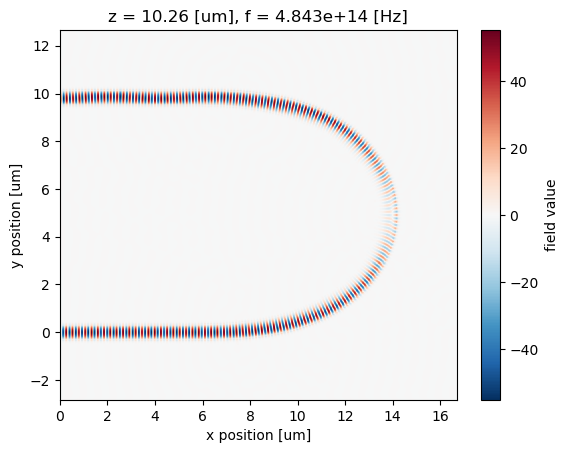

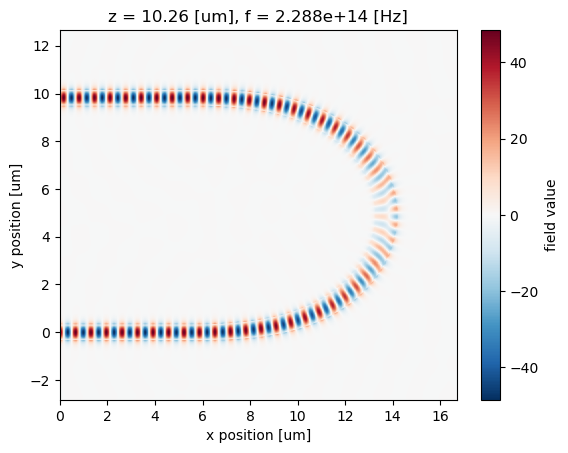

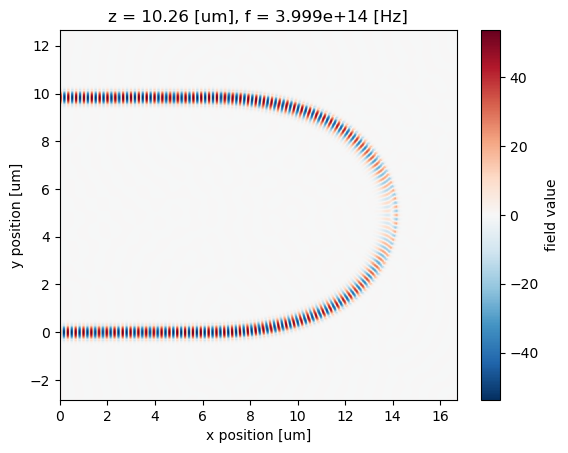

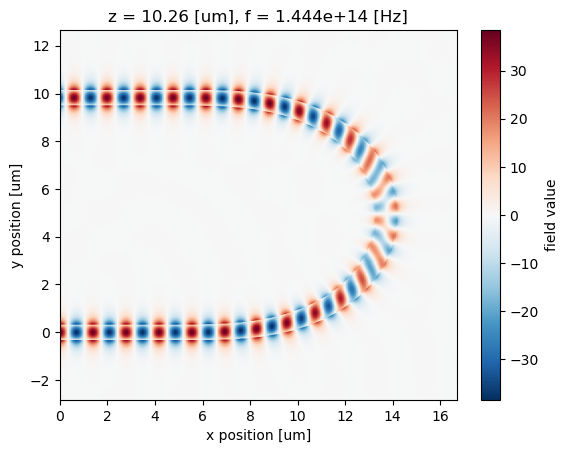

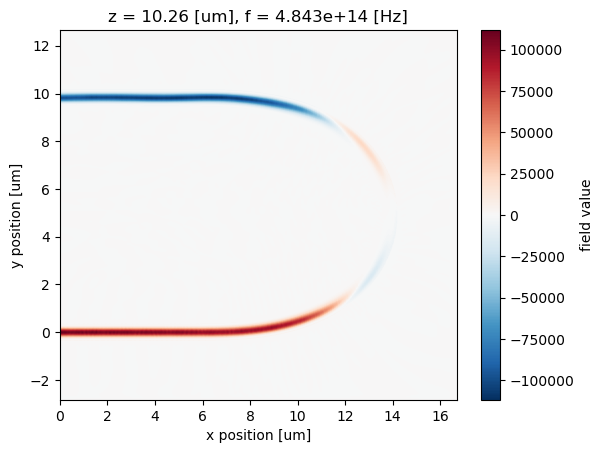

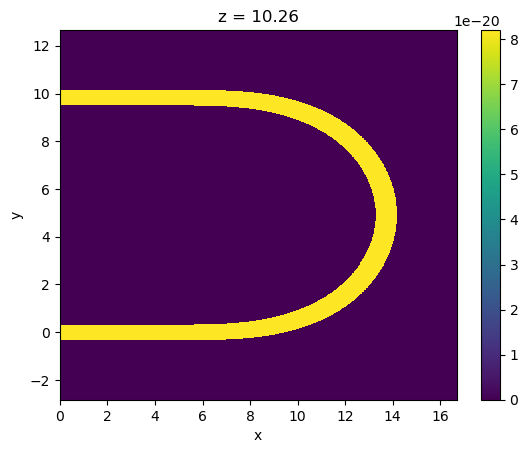

In [47]:
polarization = None
dxx = halfrace_result['efields'][0].Ex.x.values[1]-halfrace_result['efields'][0].Ex.x.values[0]
dyy = halfrace_result['efields'][0].Ex.y.values[1]-halfrace_result['efields'][0].Ex.y.values[0]
dzz = halfrace_result['efields'][0].Ex.z.values[1]-halfrace_result['efields'][0].Ex.z.values[0]
for i,efield in enumerate(halfrace_result['efields']):
    z_i = np.argmin(np.abs(efield.Ex.z.values-np.mean(efield.Ex.z.values)))
    efield.Ey.real.isel(z=z_i).plot(x='x', y='y')
    plt.show()
    conjugate = journey.envs['nonlinear']['unit_ks'][i]*journey.envs['nonlinear']['mode_factors'][i]
    if polarization is None:
        polarization = efield.Ey.isel(f=0).copy() if conjugate == 1 else np.conj(efield.Ey.isel(f=0)).copy() if conjugate == -1 else 1
    else:
        polarization *= efield.Ey.isel(f=0) if conjugate == 1 else np.conj(efield.Ey.isel(f=0)) if conjugate == -1 else 1



# z_i = np.argmin(np.abs(halfrace_result['n2'].z_range-halfrace_result['n2'].center[2]))
# print(polarization)
polarization.real.isel(z=z_i).plot(x='x', y='y')
plt.show()
halfrace_result['n2'].isel(z=z_i).plot(x='x', y='y')